# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ceph_path = Path.home() / 'ceph/DATA/Chromatin/DynCondPaper'



cuda


### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

# Figure 7

1606
2158
4627
7307
7403
8070
4.588142181763206


/tmp/ipykernel_1527941/142917992.py:54: RuntimeWarning: invalid value encountered in power
  return -prefactor* gamma_prime * (np.power(l, -1/3) - np.power(l_tot-l, -1/3))
/tmp/ipykernel_1527941/142917992.py:54: RuntimeWarning: invalid value encountered in power
  return -prefactor* gamma_prime * (np.power(l, -1/3) - np.power(l_tot-l, -1/3))
/tmp/ipykernel_1527941/142917992.py:54: RuntimeWarning: invalid value encountered in power
  return -prefactor* gamma_prime * (np.power(l, -1/3) - np.power(l_tot-l, -1/3))
/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


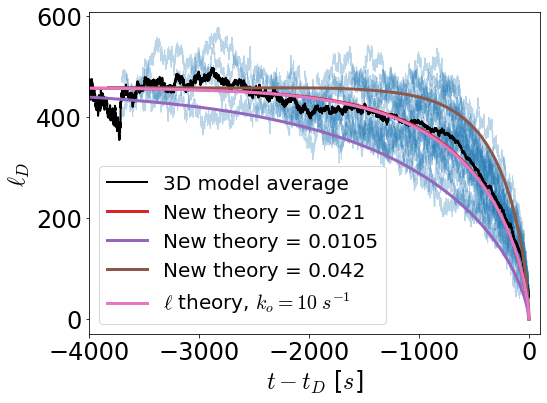

In [11]:
fig, axarr = plt.subplots(1,1, figsize=(8,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['dissolve'].items():
        try:
            clust_arr = d_set[:,1]
            condition = clust_arr > 40

            time_arr = d_set[condition,0]
            clust_arr = clust_arr[condition]
            if min(clust_arr) < 45:
                last_time_step = max(time_arr)
                if len(largest_time_arr) < len(time_arr):
                    print(len(time_arr))
                    largest_time_arr = time_arr
                _ = axarr.plot(time_arr-last_time_step , clust_arr, color='tab:blue', **plot_params)
                cluster_size_list += [clust_arr]
        except:
            print("Error")
            print(name)
            print(d_set[:,1])
            print(d_set[:,0])
            pass
            

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
_ = axarr.plot(largest_time_arr-last_time_step, mean_size_arr, label="3D model average", color='k')


_ = axarr.set_ylabel('$\ell_D$ ' )
_ = axarr.set_xlabel('$t - t_D$ [$s$]')


# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=5

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)
print(max_ld)

def new_cond_deriv(t, l, l_tot, gamma, alpha, prefactor=.021):
    gamma_prime = 8 * np.power(6, 2.0 / 3.0) * alpha * gamma * np.cbrt(np.pi / alpha)
    return -prefactor* gamma_prime * (np.power(l, -1/3) - np.power(l_tot-l, -1/3))
    


sol = solve_ivp(
    new_cond_deriv,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=(2*max_ld, gamma, alpha),
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr.plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C3", label=f"New theory = {.021}", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]*100, color="C4", label="$\ell$ theory $k_o = 10 s^{-1}$", linestyle="-", linewidth=3)

sol = solve_ivp(
    new_cond_deriv,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=(2*max_ld, gamma, alpha, .021*.5),
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr.plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C4", label=f"New theory = {.021*.5}", linestyle="-", linewidth=3)

sol = solve_ivp(
    new_cond_deriv,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=(2*max_ld, gamma, alpha, .021*2),
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr.plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C5", label=f"New theory = {.021*2}", linestyle="-", linewidth=3)

sol = solve_ivp(
    two_cond_size_continuous_deriv,
    [0, tmax],
    [max_ld + 0.001, max_ld - 0.001],
    args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
    dense_output=True,
)
# _ = axarr.plot((sol.t-sol.t[-1])/30., sol.y[1]*100, color="C1", label="$\ell$ theory $k_o = 30 s^{-1}$", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/20., sol.y[1]*100, color="C2", label="$\ell$ theory $k_o = 20 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]/b, color="C6", label="$\ell$ theory, $k_o = 10\; s^{-1}$", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]*100, color="C4", label="$\ell$ theory $k_o = 10 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.set_xlim(-4000, 100)

axarr.legend()

fig.tight_layout()
fig.savefig("Figure7/dissolve_event_sync.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig7_dissolve_event_sync.png", dpi=300, bbox_inches="tight")

1606
2158
4627
7307
7403
8070


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


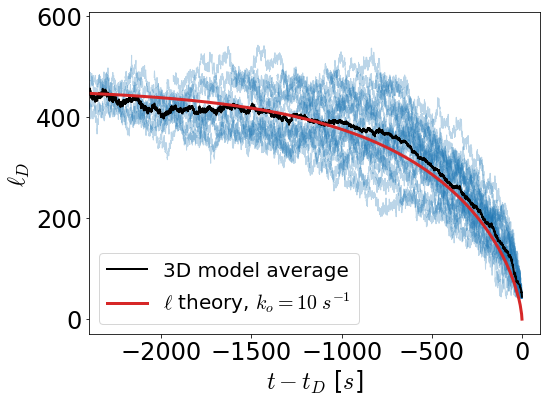

In [3]:
fig, axarr = plt.subplots(1,1, figsize=(8,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['dissolve'].items():
        try:
            clust_arr = d_set[:,1]
            condition = clust_arr > 40

            time_arr = d_set[condition,0]
            clust_arr = clust_arr[condition]
            if min(clust_arr) < 45:
                last_time_step = max(time_arr)
                if len(largest_time_arr) < len(time_arr):
                    print(len(time_arr))
                    largest_time_arr = time_arr
                _ = axarr.plot(time_arr-last_time_step , clust_arr, color='tab:blue', **plot_params)
                cluster_size_list += [clust_arr]
        except:
            print("Error")
            print(name)
            print(d_set[:,1])
            print(d_set[:,0])
            pass
            

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
_ = axarr.plot(largest_time_arr-last_time_step, mean_size_arr, label="3D model average", color='k')


_ = axarr.set_ylabel('$\ell_D$ ' )
_ = axarr.set_xlabel('$t - t_D$ [$s$]')


# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=5

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)


sol = solve_ivp(
    two_cond_size_continuous_deriv,
    [0, tmax],
    [max_ld + 0.001, max_ld - 0.001],
    args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
    dense_output=True,
)
# _ = axarr.plot((sol.t-sol.t[-1])/30., sol.y[1]*100, color="C1", label="$\ell$ theory $k_o = 30 s^{-1}$", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/20., sol.y[1]*100, color="C2", label="$\ell$ theory $k_o = 20 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]*100, color="C3", label="$\ell$ theory, $k_o = 10\; s^{-1}$", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]*100, color="C4", label="$\ell$ theory $k_o = 10 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.set_xlim(-2400, 100)

axarr.legend()

fig.tight_layout()
fig.savefig("Figure7/dissolve_event_sync.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig7_dissolve_event_sync.png", dpi=300, bbox_inches="tight")